# Gaussian Processes with GPyTorch
[GPyTorch](https://gpytorch.ai/) is a Gaussian process framework using PyTorch.
Compared to other frameworks (GPy, sklearn), GPyTorch allows for a higher level of control at the expense of a more complicated usage.

The following components are needed:
1. A model, e.g. `gpytorch.models.ExactGP` for non-variational GPs
2. A mean function for the GP model, e.g. `gpytorch.means.ConstantMean`
3. A covariance function for the GP model, e.g. `gpytorch.kernels.MaternKernel`
4. A likelihood, e.g. `gpytorch.likelihoods.GaussianLikelihood`, for modeling the noise
5. A distribution object, e.g. `gpytorch.distributions.MultivariateNormal`, holding the posterior mean and covariance at given inputs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
import torch
import pyro

### Example data

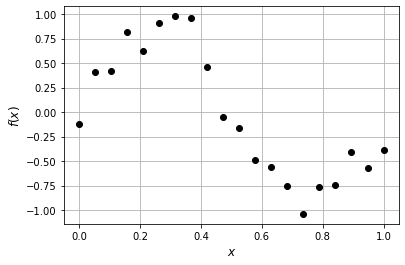

In [2]:
train_x = torch.linspace(0, 1, 20)
train_y = torch.sin(train_x * 2 * np.pi) + 0.2 * torch.randn(*train_x.shape)

fig, ax = plt.subplots(1)
ax.plot(train_x, train_y, "ko")
ax.set(xlabel="$x$", ylabel="$f(x)$")
ax.grid();

### Model definition

As in PyTorch a user-built GP model implements the following two methods:
1. An `__init__` method that takes the training data and a likelihood, and constructs the necessary objects for the model's forward method.
2. A `forward` method that for given data $x$ returns a distribution object, e.g. `MultivariateNormal` with the prior mean and covariance evaluated at $x$.

Here we use a constant mean, a Matern 5/2 kernel and a Gaussian likelihood.

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, x, y, likelihood):
        super(ExactGPModel, self).__init__(x, y, likelihood)
        self.mean = gpytorch.means.ConstantMean()
        self.kern = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(self.mean(x), self.kern(x))

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [4]:
model

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean): ConstantMean()
  (kern): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

### Parameters

The **raw** parameters are initialized to 0:

In [5]:
for name, param in model.named_parameters():
    print(f"{name:35} = {param.item()}")

likelihood.noise_covar.raw_noise    = 0.0
mean.constant                       = 0.0
kern.raw_outputscale                = 0.0
kern.base_kernel.raw_lengthscale    = 0.0


and have the following default constraints:

In [6]:
for name, constraint in model.named_constraints():
    print(f'{name:45} = {constraint}')

likelihood.noise_covar.raw_noise_constraint   = GreaterThan(1.000E-04)
kern.raw_outputscale_constraint               = Positive()
kern.base_kernel.raw_lengthscale_constraint   = Positive()


Constraints define a `transform` and `inverseTransform` method that transform from the raw to actual parameter values and vice versa. When we set the actual outputscale value to a non-zero value we see that raw and actual value differ (the actual value is the softplus $\log(1 + e^x)$ of the raw value).

In [7]:
k = model.kern
k.outputscale = 1  # set the actual value to 1
print(f"outputscale: raw={k.raw_outputscale:.3f}, actual={k.outputscale:.3f}")

outputscale: raw=0.541, actual=1.000


### Model training

As in PyTorch we need to implement the training loop ourself.

In [8]:
def print_parameters():
    loss = - mll(model(train_x), train_y).item()
    ls = model.kern.base_kernel.lengthscale.item()
    σ_kern = model.kern.outputscale.item() ** .5
    σ_noise = model.likelihood.noise.item() ** .5
    print(f"loss: {loss:.3f}, lengthscale: {ls:.3f}, scale: {σ_kern:.3f}, noise: {σ_noise:.3f}")

In [9]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    optimizer.zero_grad()
    loss = - mll(model(train_x), train_y)
    loss.backward()
    optimizer.step()
    
print_parameters()

loss: 0.059, lengthscale: 0.249, scale: 0.629, noise: 0.140


We can also use L-BFGS as a quasi-Newton optimizer.

In [10]:
model.train()
likelihood.train()

optimizer = torch.optim.LBFGS([{'params': model.parameters()}], lr=0.5)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def closure():
    optimizer.zero_grad()
    loss = - mll(model(train_x), train_y)
    loss.backward()
    return loss
    
for i in range(15):
    optimizer.step(closure)
    
print_parameters()

loss: 0.059, lengthscale: 0.246, scale: 0.625, noise: 0.139


### Predictions

Making predictions (evaluating the posterior predictive distribution) is rather straightforward.

In [11]:
# switch to evaluation mode
model.eval()
likelihood.eval()

# evaluate at new points
with torch.no_grad():
    test_x = torch.linspace(0, 1, 101)
    f_pred = model(test_x)  # noise-less predictions
    y_pred = likelihood(model(test_x))  # predictions including noise

/home/walzds/.local/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


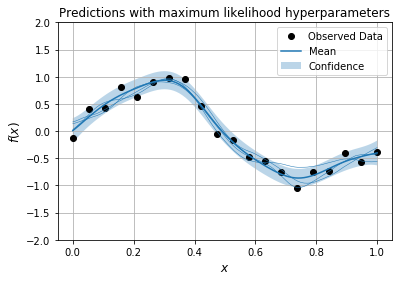

In [12]:
fig, ax = plt.subplots(1)
ax.plot(train_x, train_y, 'ko')
ax.plot(test_x, f_pred.mean)
lower, upper = f_pred.confidence_region()
ax.fill_between(test_x, lower, upper, alpha=0.3)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
f_samples = f_pred.sample(sample_shape=torch.Size([3]))
ax.plot(test_x, f_samples.T, 'C0', lw=0.5)
ax.set(xlabel="$x$", ylabel="$f(x)$", ylim=(-2, 2), title="Predictions with maximum likelihood hyperparameters")
ax.grid();

### Sampling Hyperparamters

For a Bayesian treatment we need to put priors on the hyperparameters and approximate their posterior distribution using MCMC. Priors can be either specified during initialization, or registered afterwards. Here we'll do the latter in order to extend our previously defined model.

In [13]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

model.mean.register_prior("mean_prior", gpytorch.priors.NormalPrior(0, 0.5), "constant")
model.kern.register_prior("outputscale_prior", gpytorch.priors.UniformPrior(0.05, 2), "outputscale")
model.kern.base_kernel.register_prior("lengthscale_prior", gpytorch.priors.UniformPrior(0.05, 1), "lengthscale")
model.likelihood.noise_covar.register_prior("noise_prior", gpytorch.priors.UniformPrior(0.05, 0.4), "noise")

model

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
      (noise_prior): UniformPrior(low: 0.05000000074505806, high: 0.4000000059604645)
    )
  )
  (mean): ConstantMean(
    (mean_prior): NormalPrior()
  )
  (kern): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
      (lengthscale_prior): UniformPrior(low: 0.05000000074505806, high: 1.0)
    )
    (raw_outputscale_constraint): Positive()
    (outputscale_prior): UniformPrior(low: 0.05000000074505806, high: 2.0)
  )
)

We use the NUTS implementation from Pyro to sample from the posterior distribution. This often fails, which is not a good sign as this is a low dimensional and well behaved toy example. 

In [14]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def pyro_model(x, y):
    model.pyro_sample_from_prior()
    output = model(x)
    loss = mll.pyro_factor(output, y)
    return y

nuts_kernel = pyro.infer.mcmc.NUTS(pyro_model, adapt_step_size=True)
mcmc_run = pyro.infer.mcmc.MCMC(nuts_kernel, num_samples=100, warmup_steps=200)
mcmc_run.run(train_x, train_y)

Sample: 100%|██████████| 300/300 [00:20, 14.79it/s, step size=6.32e-01, acc. prob=0.885]


Let's look at the samples. We see that the posterior distributions are similar to the priors, indicating that either the MCMC sampling has not yet converged, or that the likelihood is weak compared to the priors. 

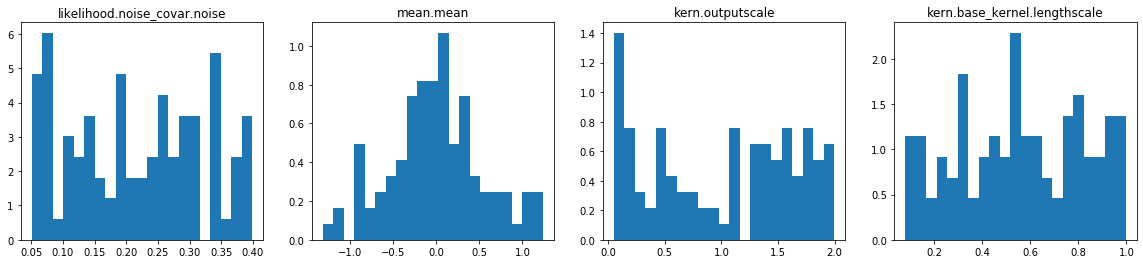

In [15]:
samples = mcmc_run.get_samples()
fig, axs = plt.subplots(1, len(samples), figsize=(5 * len(samples), 4))
for i, (k, v) in enumerate(samples.items()):
    axs[i].hist(v.squeeze(), bins=21, density=True)
    axs[i].set_title(k.rstrip("_prior"))

### Loading and evaluating the samples

We can load the sampled parameters into the model.
When evaluating the model, we now get one distribution object for each of the sampled parameter tuples.

In [17]:
model.pyro_load_from_samples(mcmc_run.get_samples())
model.eval()
test_x = torch.linspace(0, 1, 101)
output = model(test_x)  # get a distribution object for each of 100 samples

To visualize the impact we plot the predicted mean and confidence interval for a subset of the sampled parameters.

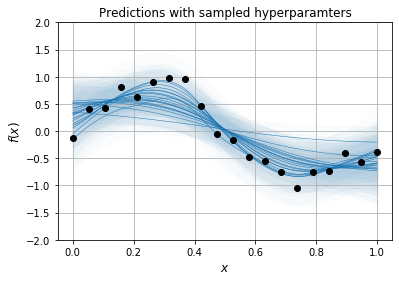

In [18]:
fig, ax = plt.subplots(1)
upper, lower = output.confidence_region()
ax.plot(train_x, train_y, "ko", zorder=10, label="Data")
for i in range(0, 100, 5):
    ax.fill_between(test_x, lower[i].detach(), upper[i].detach(), color="C0", alpha=0.02)
    ax.plot(test_x, output.mean[i].detach(), "C0", lw=0.5)
ax.set(xlabel="$x$", ylabel="$f(x)$", ylim=(-2, 2), title="Predictions with sampled hyperparamters")
ax.grid();

In [19]:
%load_ext watermark
%watermark -v -m -p gpytorch,torch,pyro

CPython 3.8.0
IPython 7.9.0

gpytorch 0.3.6
torch 1.3.1
pyro 1.0.0

compiler   : GCC 9.2.0
system     : Linux
release    : 4.4.0-43-Microsoft
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit
